In [3]:
import pyspark
import dxpy
import dxdata
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import countDistinct

ModuleNotFoundError: No module named 'pyspark'

# load the dataset

In [3]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [4]:
# Init pyspark and load dataframe
OMOP_TABLE = "omop_drug_era"  # 'omop_drug_era', 'omop_drug_exposure'

# Load dose era table
ode = dataset[OMOP_TABLE]

field_names = [f.name for f in ode.fields]

df = ode.retrieve_fields(names=field_names, engine=dxdata.connect())
# df = df.drop("eid")

print(f"Number of entries {df.count()}")
df.show(5)

Number of entries 19959413
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
|    eid|  drug_era_id|drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
|6021257|1236950609195|       19005129|         12/05/2014|       10/06/2014|                  1|       0|
|3832658| 798863919105|         743670|         30/03/2011|       02/09/2011|                  5|      12|
|3430966| 721554547993|       19008994|         12/10/2010|       07/11/2010|                  1|       0|
|2127268| 910533073010|         755695|         23/10/2006|       04/10/2007|                  6|      23|
|5185705| 317827646206|       19010400|         30/07/1999|       28/08/1999|                  1|       0|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showi

In [5]:
drug_era_atc_pandas = pd.read_csv("drug_era_atc.tsv", sep="\t")
drug_era_atc_pandas.rename(columns={"_c13": "atc_code"}, inplace=True)

In [6]:
drug_era_atc_df = spark.createDataFrame(drug_era_atc_pandas)

df_with_atc = df.join(drug_era_atc_df, on="drug_concept_id", how="left")

# Step 4: Select relevant columns
df_with_atc = df_with_atc.select(
    df.columns + ["concept_name"] + ["atc_code"]
)  # Keep all original columns and add '_c13' (ATC code)
print(f"Number of entries {df_with_atc.count()}")
df_with_atc.show(5)

/cluster/spark/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number of entries 41473278
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+------------+--------+
|    eid|  drug_era_id|drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|concept_name|atc_code|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+------------+--------+
|2798830|1391569414591|         929887|         27/08/2014|       15/02/2016|                  9|      64|lansoprazole| A02BC03|
|4678871|1116691539425|         989878|         26/04/2016|       25/05/2016|                  1|       0|   lidocaine| C01BB01|
|4678871|1116691539425|         989878|         26/04/2016|       25/05/2016|                  1|       0|   lidocaine| C05AD01|
|4678871|1116691539425|         989878|         26/04/2016|       25/05/2016|                  1|       0|   lidocaine| D04AB01|
|4678871|1116691539425|         989878|         26/04/2016|       25/0

# filter through times

In [15]:
drug_times_df_pandas = pd.read_csv("drug_times_count.csv")
drug_times_df = spark.createDataFrame(drug_times_df_pandas)
drug_times_df.show(5)

+---------------+-----------+
|drug_concept_id|times_taken|
+---------------+-----------+
|        1112807|     927199|
|        1125315|     712882|
|        1713332|     555088|
|        1201620|     406766|
|        1115572|     378066|
+---------------+-----------+
only showing top 5 rows



/cluster/spark/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [21]:
df_combined = df_with_atc.join(drug_times_df, on="drug_concept_id", how="left")
filtered_df_1 = df_combined.filter(
    (df_combined["times_taken"] >= 313) & (df_combined["times_taken"] <= 4012)
)
filtered_df_1 = filtered_df_1.drop("times_taken")
print(f"Number of entries {filtered_df_1.count()}")
filtered_df_1.show(5)

Number of entries 790719
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|drug_concept_id|    eid|  drug_era_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|concept_name|atc_code|
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|         714684|3136611|1520418438667|         02/01/1998|       09/09/1998|                  9|      26|  nefazodone| N06AX06|
|         714684|3607731| 266288044363|         18/01/2000|       21/03/2000|                  2|       0|  nefazodone| N06AX06|
|         714684|2723691|1434519092181|         11/02/1997|       04/06/1997|                  4|      33|  nefazodone| N06AX06|
|         714684|3136611| 395137011982|         06/10/1995|       24/03/1996|                  6|      17|  nefazodone| N06AX06|
|         714684|3607731| 841813613114|         27/05/2002|       14/03/

In [20]:
unique_drug_concepts = filtered_df_1.select("drug_concept_id").distinct().count()
unique_drug_concepts

405

# filter through people

In [22]:
drug_people_df_pandas = pd.read_csv("drug_people_count.csv")
drug_people_df = spark.createDataFrame(drug_people_df_pandas)
drug_people_df.show(5)

+---------------+-------------------+
|drug_concept_id|unique_people_count|
+---------------+-------------------+
|        1713332|             141912|
|        1125315|             116112|
|         975125|             108940|
|        1201620|             102314|
|        1124300|              95165|
+---------------+-------------------+
only showing top 5 rows



/cluster/spark/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [26]:
df_combined_2 = filtered_df_1.join(drug_people_df, on="drug_concept_id", how="left")
filtered_df_2 = df_combined_2.filter(
    (df_combined_2["unique_people_count"] >= 121)
    & (df_combined_2["unique_people_count"] <= 1411)
)
filtered_df_2 = filtered_df_2.drop("unique_people_count")
print(f"Number of entries {filtered_df_2.count()}")
filtered_df_2.show(5)

Number of entries 596398
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|drug_concept_id|    eid|  drug_era_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|concept_name|atc_code|
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|         714684|3136611|1520418438667|         02/01/1998|       09/09/1998|                  9|      26|  nefazodone| N06AX06|
|         714684|3607731| 266288044363|         18/01/2000|       21/03/2000|                  2|       0|  nefazodone| N06AX06|
|         714684|2723691|1434519092181|         11/02/1997|       04/06/1997|                  4|      33|  nefazodone| N06AX06|
|         714684|3136611| 395137011982|         06/10/1995|       24/03/1996|                  6|      17|  nefazodone| N06AX06|
|         714684|3607731| 841813613114|         27/05/2002|       14/03/

In [27]:
unique_drug_concepts = filtered_df_2.select("drug_concept_id").distinct().count()
unique_drug_concepts

335

# filter through ATC Codes

In [32]:
atc_codes_of_interest = ["A10", "J01", "L01", "N05", "N06", "S01"]

filtered_df_3 = filtered_df_2.filter(
    filtered_df_2["atc_code"].rlike(
        "|".join([f"^{code}" for code in atc_codes_of_interest])
    )
)
print(f"Number of entries {filtered_df_3.count()}")
filtered_df_3.show(5)

Number of entries 114824
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|drug_concept_id|    eid|  drug_era_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|concept_name|atc_code|
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+
|         714684|3136611|1520418438667|         02/01/1998|       09/09/1998|                  9|      26|  nefazodone| N06AX06|
|         714684|3607731| 266288044363|         18/01/2000|       21/03/2000|                  2|       0|  nefazodone| N06AX06|
|         714684|2723691|1434519092181|         11/02/1997|       04/06/1997|                  4|      33|  nefazodone| N06AX06|
|         714684|3136611| 395137011982|         06/10/1995|       24/03/1996|                  6|      17|  nefazodone| N06AX06|
|         714684|3607731| 841813613114|         27/05/2002|       14/03/

In [33]:
unique_drug_concepts = filtered_df_3.select("drug_concept_id").distinct().count()
unique_drug_concepts

74

In [72]:
filtered_df_3_atc = filtered_df_3.select("drug_concept_id", "atc_code").dropDuplicates()
filtered_df_3_atc.show(5)

+---------------+--------+
|drug_concept_id|atc_code|
+---------------+--------+
|         785788| N05AH03|
|        1377141| L01XX05|
|       19088223| J01CA08|
|         720727| N05CF03|
|         735979| N05AX08|
+---------------+--------+
only showing top 5 rows



In [52]:
filtered_df_3_atc_pandas = filtered_df_3_atc.toPandas()

NameError: name 'filtered_df_3_atc' is not defined

In [79]:
# Create a dictionary to store the sampled drug_concept_ids for each ATC code
sampled_drugs = {}

# Sample 3 drug_concept_ids for each ATC code
for atc_code in atc_codes_of_interest:
    # Filter the dataframe for the current ATC code
    filtered = filtered_df_3_atc_pandas[
        filtered_df_3_atc_pandas["atc_code"].str.startswith(atc_code)
    ]

    # Sample 3 drug_concept_ids (or all if less than 3 are available)
    sampled = filtered["drug_concept_id"].sample(
        n=min(3, len(filtered)), random_state=42
    )

    # Store the sampled drug_concept_ids in the dictionary
    sampled_drugs[atc_code] = sampled.tolist()

# Print the results
for atc_code, drugs in sampled_drugs.items():
    print(f"ATC code {atc_code}: {drugs}")

# Create a new dataframe with the sampled drug_concept_ids
the_18_sampled_drug_concept_id = pd.DataFrame(
    [(atc, drug) for atc, drugs in sampled_drugs.items() for drug in drugs],
    columns=["atc_code", "drug_concept_id"],
)

# Display the new dataframe
print("\nthe_18_sampled_drug_concept_id:")
print(the_18_sampled_drug_concept_id)

ATC code A10: ['40239216', '1583722', '19122137']
ATC code J01: ['1778162', '19095043', '1742253']
ATC code L01: ['978236', '1436650', '1377141']
ATC code N05: ['785788', '708298', '19005147']
ATC code N06: ['705755', '733523', '710650']
ATC code S01: ['929435', '902722', '967496']

the_18_sampled_drug_concept_id:
   atc_code drug_concept_id
0       A10        40239216
1       A10         1583722
2       A10        19122137
3       J01         1778162
4       J01        19095043
5       J01         1742253
6       L01          978236
7       L01         1436650
8       L01         1377141
9       N05          785788
10      N05          708298
11      N05        19005147
12      N06          705755
13      N06          733523
14      N06          710650
15      S01          929435
16      S01          902722
17      S01          967496


In [83]:
sampled_ids = the_18_sampled_drug_concept_id["drug_concept_id"].tolist()
filtered_df_4 = filtered_df_3.filter(filtered_df_3["drug_concept_id"].isin(sampled_ids))
print(f"Number of entries {filtered_df_4.count()}")
filtered_df_4.show(5)

Number of entries 27907
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+---+
|drug_concept_id|    eid|  drug_era_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|concept_name|atc_code| rn|
+---------------+-------+-------------+-------------------+-----------------+-------------------+--------+------------+--------+---+
|       40239216|4439949| 137439001156|         17/03/2016|       06/07/2016|                  4|       5| linagliptin| A10BH05|  1|
|       40239216|4819861|1176821071323|         08/12/2015|       13/06/2017|                 21|      41| linagliptin| A10BH05|  2|
|       40239216|4153502|1262720420766|         18/10/2013|       19/05/2014|                  8|      36| linagliptin| A10BH05|  3|
|       40239216|2856868|1056562007699|         27/03/2017|       06/06/2017|                  3|       0| linagliptin| A10BH05|  4|
|       40239216|3102993| 858993544722|      

In [82]:
unique_drug_concepts = filtered_df_4.select("drug_concept_id").distinct().count()
unique_drug_concepts

18

In [87]:
filtered_df_4_pandas = filtered_df_4.toPandas()
filtered_df_4_pandas.to_csv("filtered_df_4.csv", index=False)

# individual filtering

In [84]:
people_drug_variety_unsorted = filtered_df_4.groupBy("eid").agg(
    countDistinct("drug_concept_id").alias("distinct_drugs_taken")
)
people_drug_variety = people_drug_variety_unsorted.orderBy(
    "distinct_drugs_taken", ascending=False
)
people_drug_variety.show()

+-------+--------------------+
|    eid|distinct_drugs_taken|
+-------+--------------------+
|5052764|                   4|
|2136797|                   4|
|1359149|                   4|
|2416254|                   3|
|1404102|                   3|
|2801450|                   3|
|5663396|                   3|
|5310374|                   3|
|3650084|                   3|
|1954061|                   3|
|1863067|                   3|
|4721164|                   3|
|5142194|                   3|
|2795068|                   3|
|5844959|                   3|
|3788884|                   3|
|3853370|                   3|
|2449665|                   3|
|1536799|                   3|
|1805604|                   3|
+-------+--------------------+
only showing top 20 rows



In [85]:
people_drug_variety_pandas = people_drug_variety.toPandas()
statistics_people_drug_variety = people_drug_variety_pandas[
    "distinct_drugs_taken"
].describe()
print(statistics_people_drug_variety)

count    9394.000000
mean        1.109432
std         0.331064
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: distinct_drugs_taken, dtype: float64


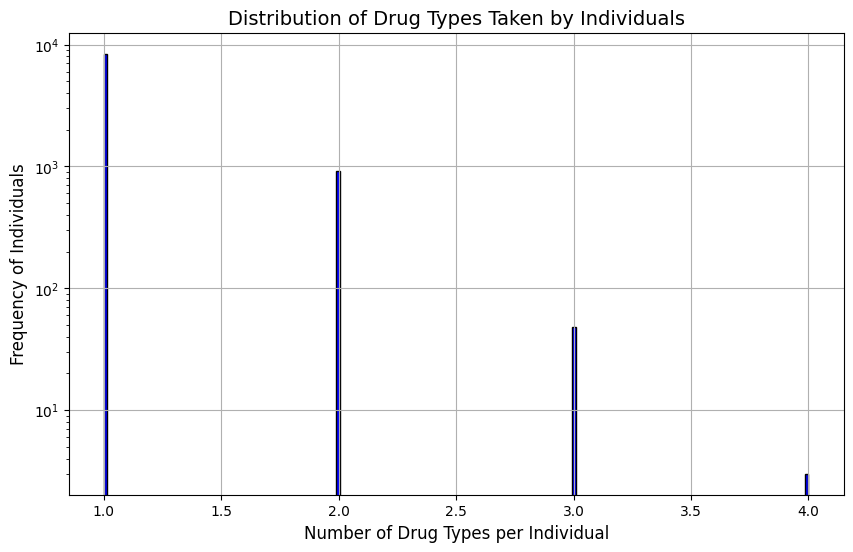

In [86]:
plt.figure(figsize=(10, 6))
plt.hist(
    people_drug_variety_pandas["distinct_drugs_taken"],
    bins=200,
    color="blue",
    edgecolor="black",
)
plt.title("Distribution of Drug Types Taken by Individuals", fontsize=14)
plt.xlabel("Number of Drug Types per Individual", fontsize=12)
plt.ylabel("Frequency of Individuals", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

# check on the focused dataset

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
filtered_df_4 = pd.read_csv("filtered_df_4.csv")
filtered_df_4.head()

,drug_concept_id,eid,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code
0,785788,2712366,790274024660,27/03/2014,12/06/2014,2,19,olanzapine,N05AH03
1,785788,4326537,1305670111057,20/08/2014,18/09/2014,1,0,olanzapine,N05AH03
2,785788,4326537,1151051282525,16/02/2011,25/05/2011,5,1,olanzapine,N05AH03
3,785788,3873759,240518251783,15/11/2004,14/12/2004,1,0,olanzapine,N05AH03
4,785788,2712366,1133871384841,15/07/2008,08/12/2009,14,106,olanzapine,N05AH03


In [14]:
# Group by all columns except 'atc_code' and aggregate the ATC codes
filtered_df_4_grouped = (
    filtered_df_4.groupby([col for col in filtered_df_4.columns if col != "atc_code"])
    .agg({"atc_code": lambda x: ", ".join(sorted(set(x)))})
    .reset_index()
)

print("Shape before grouping:", filtered_df_4.shape)
print("Shape after grouping:", filtered_df_4_grouped.shape)

filtered_df_4_grouped.head()

Shape before grouping: (27907, 9)
Shape after grouping: (23944, 9)


,drug_concept_id,eid,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code
0,705755,1006104,223338385579,13/11/2001,16/11/2001,1,0,trimipramine,N06AA06
1,705755,1060942,901943214204,13/04/1994,22/04/1994,1,0,trimipramine,N06AA06
2,705755,1072215,266288039904,08/04/1998,27/04/1998,1,0,trimipramine,N06AA06
3,705755,1072215,1013612295560,30/06/1997,24/08/1997,2,17,trimipramine,N06AA06
4,705755,1072215,1013612312206,09/09/2003,28/09/2003,1,0,trimipramine,N06AA06


In [ ]:
# save the grouped dataframe to csv
filtered_df_4_grouped.to_csv("filtered_df_4_grouped.csv", index=False)

In [16]:
# Count occurrences of each drug
drug_counts = filtered_df_4_grouped["drug_concept_id"].value_counts().reset_index()
drug_counts.columns = ["drug_concept_id", "count"]

# Sort by count in descending order
drug_counts = drug_counts.sort_values("count", ascending=False)

# Add drug names and ATC codes
drug_info = filtered_df_4_grouped[
    ["drug_concept_id", "concept_name", "atc_code"]
].drop_duplicates()
drug_counts = drug_counts.merge(drug_info, on="drug_concept_id", how="left")

# Reorder columns
drug_counts = drug_counts[["drug_concept_id", "concept_name", "atc_code", "count"]]

print("Number of unique drugs:", len(drug_counts))
print(drug_counts)

Number of unique drugs: 18
    drug_concept_id       concept_name          atc_code  count
0            785788         olanzapine           N05AH03   3947
1            705755       trimipramine           N06AA06   2329
2            967496         lodoxamide           S01GX05   1821
3            929435      acetazolamide           S01EC01   1751
4            978236       eflornithine           L01XX79   1648
5           1778162         cefuroxime  J01DC02, S01AA27   1496
6            708298          midazolam           N05CD08   1337
7           1583722          exenatide           A10BJ01   1322
8           1742253       levofloxacin  J01MA12, S01AE05   1294
9            710650          modafinil           N06BA07   1124
10          1377141        hydroxyurea           L01XX05   1102
11         19005147  methotrimeprazine           N05AA02   1030
12         40239216        linagliptin           A10BH05    911
13          1436650     mercaptopurine           L01BB02    626
14           

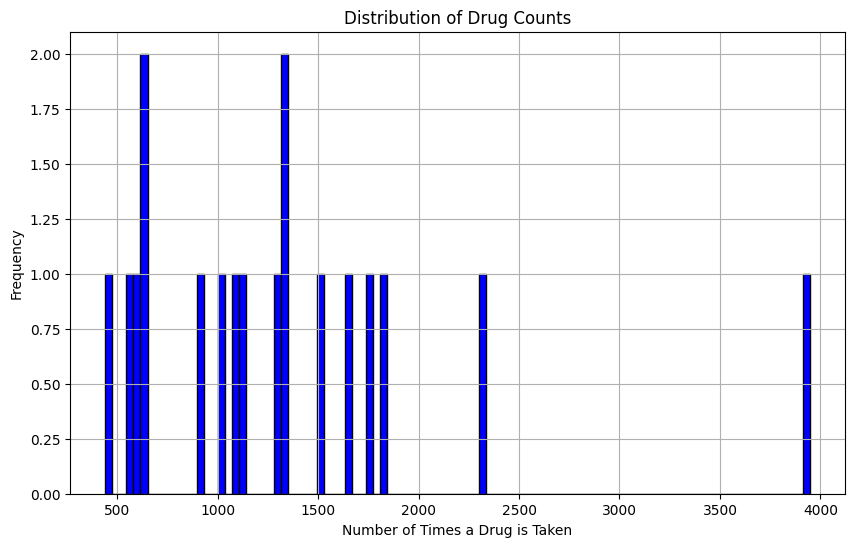

In [19]:
# plot a histogram of the drug counts
plt.figure(figsize=(10, 6))
plt.hist(drug_counts["count"], bins=100, color="blue", edgecolor="black")
plt.title("Distribution of Drug Counts")
plt.xlabel("Number of Times a Drug is Taken")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [24]:
# exclude the drug 785788 and 705755 because they are outliers
filtered_df_5 = filtered_df_4_grouped[
    ~filtered_df_4_grouped["drug_concept_id"].isin([785788, 705755])
]
filtered_df_5.head()

,drug_concept_id,eid,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code
2329,708298,1001837,1700807090784,12/12/2013,10/01/2014,1,0,midazolam,N05CD08
2330,708298,1002112,1666447356341,29/04/2013,28/05/2013,1,0,midazolam,N05CD08
2331,708298,1012539,1194000953715,05/09/2013,26/10/2013,4,0,midazolam,N05CD08
2332,708298,1012652,1065151983292,16/02/2011,17/03/2011,1,0,midazolam,N05CD08
2333,708298,1024103,996432425515,14/03/2016,12/04/2016,1,0,midazolam,N05CD08


In [27]:
# save the filtered dataframe to csv
filtered_df_5.to_csv("filtered_df_5.csv", index=False)

In [50]:
# see how many rows are in the dataframe
print(f"Number of entries {filtered_df_5.count()}")

Number of entries drug_concept_id        17668
eid                    17668
drug_era_id            17668
drug_era_start_date    17668
drug_era_end_date      17668
drug_exposure_count    17668
gap_days               17668
concept_name           17668
atc_code               17668
dtype: int64


In [25]:
# Count occurrences of each drug
drug_counts = filtered_df_5["drug_concept_id"].value_counts().reset_index()
drug_counts.columns = ["drug_concept_id", "count"]

# Sort by count in descending order
drug_counts = drug_counts.sort_values("count", ascending=False)

# Add drug names and ATC codes
drug_info = filtered_df_5[
    ["drug_concept_id", "concept_name", "atc_code"]
].drop_duplicates()
drug_counts = drug_counts.merge(drug_info, on="drug_concept_id", how="left")

# Reorder columns
drug_counts = drug_counts[["drug_concept_id", "concept_name", "atc_code", "count"]]

print("Number of unique drugs:", len(drug_counts))
print(drug_counts)

Number of unique drugs: 16
    drug_concept_id       concept_name          atc_code  count
0            967496         lodoxamide           S01GX05   1821
1            929435      acetazolamide           S01EC01   1751
2            978236       eflornithine           L01XX79   1648
3           1778162         cefuroxime  J01DC02, S01AA27   1496
4            708298          midazolam           N05CD08   1337
5           1583722          exenatide           A10BJ01   1322
6           1742253       levofloxacin  J01MA12, S01AE05   1294
7            710650          modafinil           N06BA07   1124
8           1377141        hydroxyurea           L01XX05   1102
9          19005147  methotrimeprazine           N05AA02   1030
10         40239216        linagliptin           A10BH05    911
11          1436650     mercaptopurine           L01BB02    626
12           902722         tobramycin  J01GB01, S01AA12    625
13         19122137       vildagliptin           A10BH02    592
14         19

In [51]:
print(drug_counts["count"].describe())

count      16.000000
mean     1104.250000
std       449.600786
min       441.000000
25%       625.750000
50%      1113.000000
75%      1376.750000
max      1821.000000
Name: count, dtype: float64


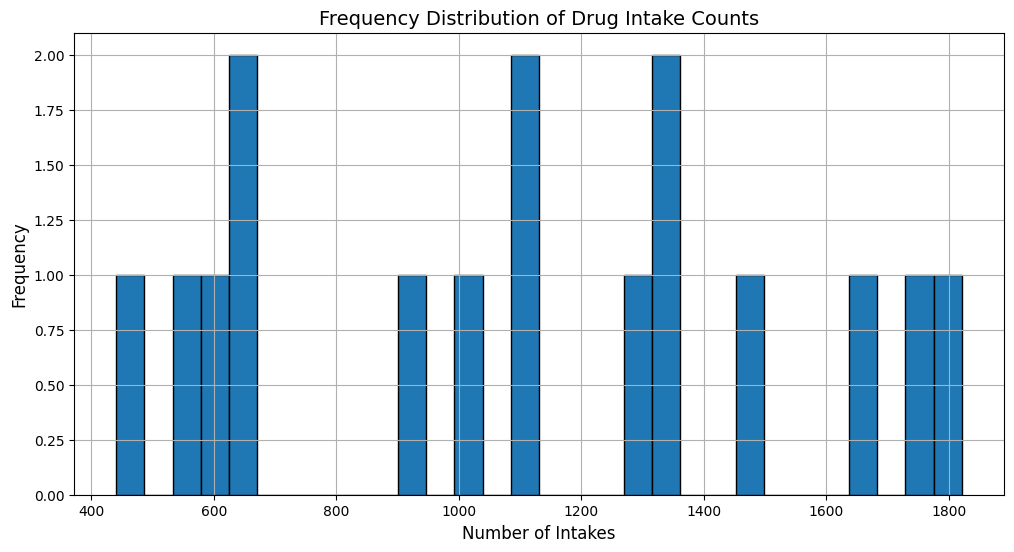

In [44]:
plt.figure(figsize=(12, 6))
plt.hist(drug_counts["count"], bins=30, edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

In [30]:
# number of unique people
unique_people = filtered_df_5["eid"].nunique()
print(f"Number of unique people: {unique_people}")

Number of unique people: 8117


Distribution of how many people take the same drug:
    drug_concept_id       concept_name          atc_code  unique_people_count
0            708298          midazolam           N05CD08                 1219
4            929435      acetazolamide           S01EC01                 1157
11          1778162         cefuroxime  J01DC02, S01AA27                 1039
10          1742253       levofloxacin  J01MA12, S01AE05                  908
12         19005147  methotrimeprazine           N05AA02                  835
5            967496         lodoxamide           S01GX05                  757
15         40239216        linagliptin           A10BH05                  629
3            902722         tobramycin  J01GB01, S01AA12                  497
9           1583722          exenatide           A10BJ01                  430
6            978236       eflornithine           L01XX79                  388
13         19095043  chlortetracycline  J01AA03, S01AA02                  368
2           

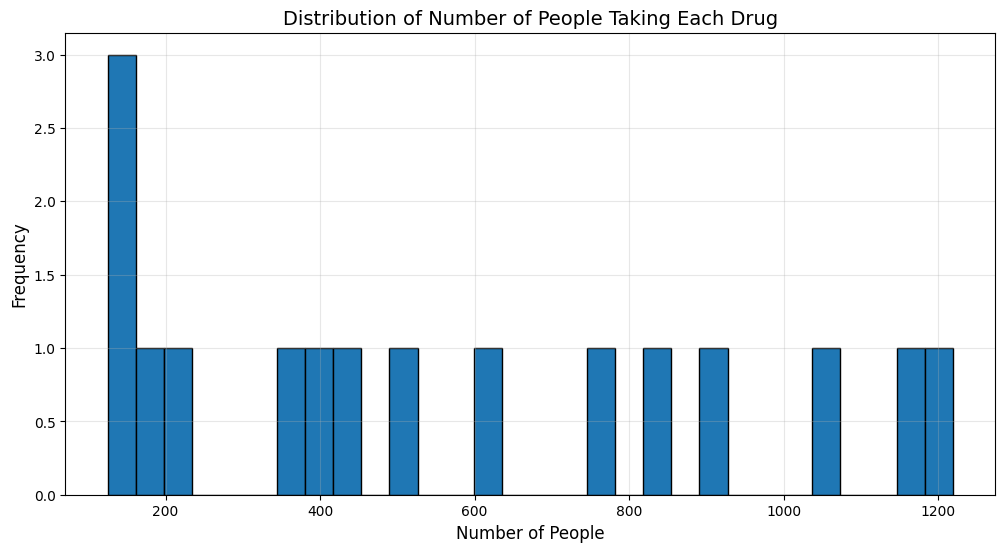


Statistics:
count      16.000000
mean      565.312500
std       377.489553
min       125.000000
25%       204.000000
50%       463.500000
75%       853.250000
max      1219.000000
Name: unique_people_count, dtype: float64


In [33]:
# distribution of how many people take the same drug
drug_people_counts = (
    filtered_df_5.groupby("drug_concept_id")["eid"].nunique().reset_index()
)
drug_people_counts.columns = ["drug_concept_id", "unique_people_count"]

# Add drug names and ATC codes
drug_info = filtered_df_5[
    ["drug_concept_id", "concept_name", "atc_code"]
].drop_duplicates()
drug_people_counts = drug_people_counts.merge(
    drug_info, on="drug_concept_id", how="left"
)

# Sort by unique_people_count in descending order
drug_people_counts = drug_people_counts.sort_values(
    "unique_people_count", ascending=False
)

# Reorder columns
drug_people_counts = drug_people_counts[
    ["drug_concept_id", "concept_name", "atc_code", "unique_people_count"]
]

print("Distribution of how many people take the same drug:")
print(drug_people_counts)

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(drug_people_counts["unique_people_count"], bins=30, edgecolor="black")
plt.title("Distribution of Number of People Taking Each Drug", fontsize=14)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print("\nStatistics:")
print(drug_people_counts["unique_people_count"].describe())

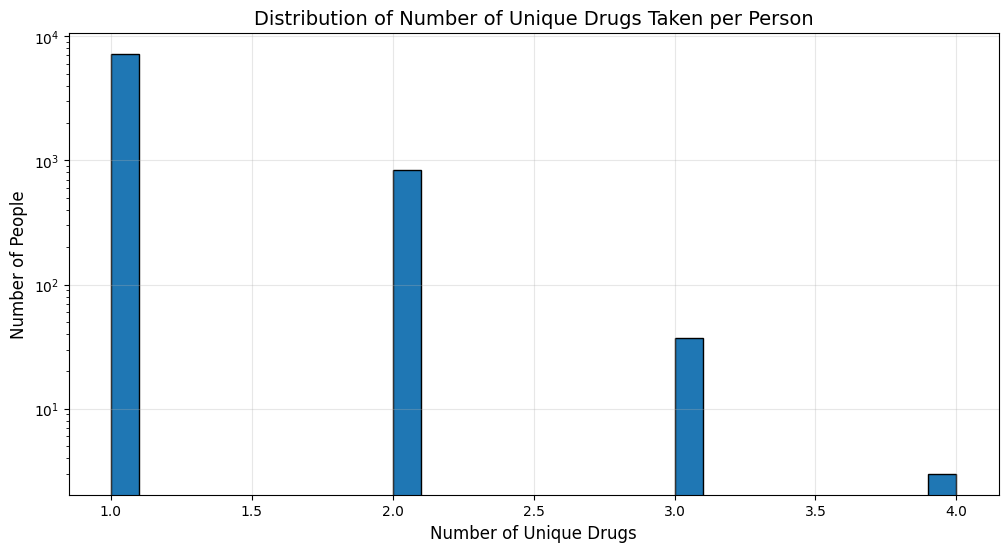


Statistics:
count    8117.000000
mean        1.114328
std         0.335567
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: unique_drugs_count, dtype: float64

Number of people taking each number of drugs:
unique_drugs_count
1    7232
2     845
3      37
4       3
Name: count, dtype: int64


In [46]:
# Distribution of how many drugs each person takes
drug_people_counts = (
    filtered_df_5.groupby("eid")["drug_concept_id"].nunique().reset_index()
)
drug_people_counts.columns = ["eid", "unique_drugs_count"]

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(drug_people_counts["unique_drugs_count"], bins=30, edgecolor="black")
plt.title("Distribution of Number of Unique Drugs Taken per Person", fontsize=14)
plt.xlabel("Number of Unique Drugs", fontsize=12)
plt.ylabel("Number of People", fontsize=12)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print("\nStatistics:")
print(drug_people_counts["unique_drugs_count"].describe())

# Print the number of people taking each number of drugs
print("\nNumber of people taking each number of drugs:")
print(drug_people_counts["unique_drugs_count"].value_counts().sort_index())